In [ ]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd # Import pandas for CSV handling
# Removed 'math' as rotation logic is no longer needed

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
# Adjusted path to be relative to the project folder, assuming 'models' is a direct child
# of the main project folder. The user's provided path was very specific,
# but a relative path is standard for project organization.
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define the root directories for input and output
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal"

# Define the scaling factor for upscaling images (using the new scale from your friend's code)
scale_factor = 12

# Create the root output directory if it doesn't exist
os.makedirs(root_output_dir, exist_ok=True)

# List of emotion folders (assuming these are the names of your subfolders)
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

# List to store all landmark data for CSV export
all_landmarks_data = []

print("Starting facial landmark detection and processing for ALL photos...")
print("Output images will be split into '_with_photo' and '_without_photo' folders.")
print("A comprehensive CSV file with landmark coordinates will also be generated.")


for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)
    
    # Define the new output subfolders for each emotion
    # E.g., processed_faces/anger/anger_with_photo/
    output_with_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_with_photo")
    # E.g., processed_faces/anger/anger_without_photo/
    output_without_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_without_photo")

    # Create these new output subdirectories if they don't exist
    os.makedirs(output_with_photo_path, exist_ok=True)
    os.makedirs(output_without_photo_path, exist_ok=True)
    
    print(f"\nProcessing emotion: {emotion}...")

    # Iterate through each image in the emotion folder
    for filename in os.listdir(input_emotion_path):
        # Ensure we only process image files
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue # Skip to the next file if image cannot be read
                
            print(f"  Processing file: {filename}")

            # Upscale the image (using the new scale_factor = 12)
            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)

            # Detect faces in the upscaled grayscale image
            faces = detector(gray)

            if len(faces) > 0:
                # Process the first detected face (assuming one main face per photo)
                face = faces[0]
                landmarks = predictor(gray, face)

                # --- Collect landmark data for CSV ---
                landmark_row = {'emotion': emotion, 'filename': filename}
                for n in range(68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    landmark_row[f'landmark_{n}_x'] = x
                    landmark_row[f'landmark_{n}_y'] = y
                all_landmarks_data.append(landmark_row)
                # --- End of CSV data collection ---

                # --- Prepare images for both output types ---
                # 1. Image with original photo and landmarks (for _with_photo folder)
                drawn_image_with_photo = upscaled_image.copy() 

                # 2. Blank image for landmarks only (for _without_photo folder)
                # Create a black background image of the same size as the upscaled image
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8) 

                # Get position of landmark 31 (index 30 in 0-based indexing) for quadrant lines
                nose_x = landmarks.part(30).x
                nose_y = landmarks.part(30).y

                # Draw quadrant lines centered at landmark 31 (only on image WITH photo)
                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1) # Green line
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1) # Green line

                drawn_index = 1 # To label the landmark points
                seen = set()    # To avoid drawing same point multiple times if coordinates overlap

                for n in range(68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y

                    if (x, y) in seen:
                        continue
                    seen.add((x, y))

                    # Define drawing properties for landmarks
                    circle_color = (0, 0, 255) # Red for circles (BGR format)
                    circle_radius =  2 # Larger radius for landmark 31 (nose)
                    fill_type = -1 # Fill the circle

                    text_font = cv2.FONT_HERSHEY_SIMPLEX
                    text_scale = 0.35
                    
                    # Offset for label (re-using your friend's logic for consistency)
                    offset_x, offset_y = -6, 10
                    if n in [37, 38, 39, 43, 44, 45]: # Upper eye points
                        offset_y = -10
                    elif n == 49: # Left mouth corner
                        offset_x = -20
                        offset_y = 6
                    elif n == 50: # Top lip center
                        offset_x = 0
                        offset_y = -8
                    elif n == 65: # Chin left
                        offset_x = -14
                        offset_y = 10
                    elif 48 <= n <= 54: # Upper lip
                        offset_y = -8
                    elif 55 <= n <= 59: # Lower lip center to right
                        offset_y = 10
                    elif 60 <= n <= 64: # Inner mouth top
                        offset_y = -8
                    elif 65 <= n <= 67: # Chin right
                        offset_y = 10
                    
                    # Draw on the image WITH photo (original background)
                    text_color_with_photo = (0, 0, 0) # Black text for visibility on varied backgrounds
                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, circle_color, fill_type)
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, text_color_with_photo, 1, cv2.LINE_AA) # Changed thickness to 1 for consistency

                    # Draw on the image WITHOUT photo (black background)
                    # Use white color for landmarks/text for high contrast on black background
                    text_color_without_photo = (255, 255, 255) # White text
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, text_color_without_photo, fill_type) 
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, text_color_without_photo, 1, cv2.LINE_AA) # Changed thickness to 1

                    drawn_index += 1

                # Save the processed images to their respective folders
                output_image_path_with_photo = os.path.join(output_with_photo_path, filename)
                cv2.imwrite(output_image_path_with_photo, drawn_image_with_photo)
                
                output_image_path_without_photo = os.path.join(output_without_photo_path, filename)
                cv2.imwrite(output_image_path_without_photo, drawn_image_without_photo)
                
            else:
                print(f"  No face detected in {filename} from {emotion} folder.")
            
            # This 'break' statement was for testing only and has been REMOVED.
            # The script will now process all images found in each folder.

print("\nAll emotion folders and photos processed successfully!")

# --- Save all collected landmark data to a single CSV file ---
if all_landmarks_data:
    df = pd.DataFrame(all_landmarks_data)
    csv_output_path = os.path.join(root_output_dir, "facial_landmarks_data.csv")
    df.to_csv(csv_output_path, index=False)
    print(f"All facial landmark coordinates saved to: {csv_output_path}")
else:
    print("No facial landmark data was collected (no faces detected or no images processed).")



Starting facial landmark detection and processing for ALL photos...
Output images will be split into '_with_photo' and '_without_photo' folders.
A comprehensive CSV file with landmark coordinates will also be generated.

Processing emotion: anger...
  Processing file: S010_004_00000017.png
  Processing file: S010_004_00000018.png
  Processing file: S010_004_00000019.png
  Processing file: S011_004_00000019.png
  Processing file: S011_004_00000020.png
  Processing file: S011_004_00000021.png
  Processing file: S014_003_00000028.png
  Processing file: S014_003_00000029.png
  Processing file: S014_003_00000030.png
  Processing file: S022_005_00000030.png
  Processing file: S022_005_00000031.png
  Processing file: S022_005_00000032.png
  Processing file: S026_003_00000013.png
  Processing file: S026_003_00000014.png
  Processing file: S026_003_00000015.png
  Processing file: S028_001_00000022.png
  Processing file: S028_001_00000023.png
  Processing file: S028_001_00000024.png
  Processing

In [5]:
import pandas as pd

# Step 1: Load the CSV file generated from landmark extraction
csv_path = "processed_faces_newFinal/facial_landmarks_data.csv"
df = pd.read_csv(csv_path)

# Step 2: Drop the filename column (not required for training)
if 'filename' in df.columns:
    df.drop('filename', axis=1, inplace=True)

cleaned_csv_path = 'processed_faces_newFinal/cleaned_facial landmarks_data.csv'  # <-- Cleaned version


# # Step 2: Show basic info
# print("Original Dataset Info:")
# print(df.info())
# print("\nSample Rows:")
# print(df.head())

# Step 3: Drop rows with any missing values
df.dropna(inplace=True)

# Step 4: Ensure all coordinate columns are numeric (except filename and emotion)
columns_to_check = df.columns.difference(['filename', 'emotion'])
df[columns_to_check] = df[columns_to_check].apply(pd.to_numeric, errors='coerce')

# Step 5: Drop any rows that still contain NaNs after conversion
df.dropna(inplace=True)

# Step 6: Drop duplicate rows
df.drop_duplicates(inplace=True)

# Step 7: Reset index
df.reset_index(drop=True, inplace=True)

# Step 8: Save cleaned data
df.to_csv(cleaned_csv_path, index=False)
print(f"\n✅ Cleaned data saved to: {cleaned_csv_path}")






✅ Cleaned data saved to: processed_faces_newFinal/cleaned_facial landmarks_data.csv


In [2]:
import sklearn
print(sklearn.__version__)


1.6.1


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Input CSV file path (change as needed)
input_csv_path = 'processed_faces_newFinal/cleaned_facial landmarks_data.csv'  # or your input CSV file

# Read the CSV file into a DataFrame
df = pd.read_csv(input_csv_path)

# Initialize the Label Encoder
le = LabelEncoder()

# Fit and transform the 'emotion' column
df['emotion'] = le.fit_transform(df['emotion'])

# Print mapping for reference
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Emotion Label Mapping:")
print(label_mapping)

# Save the DataFrame with encoded emotion labels to a new CSV file
encoded_csv_path = 'processed_faces_newFinal/encoded_landmarks.csv'  # Change filename/path as needed
df.to_csv(encoded_csv_path, index=False)
print(f"Encoded data saved to {encoded_csv_path}")



Emotion Label Mapping:
{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'sadness': 5, 'surprise': 6}
Encoded data saved to processed_faces_newFinal/encoded_landmarks.csv


C:\Users\sahug\AppData\Local\Temp\ipykernel_22712\265298241.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='emotion', palette='viridis')


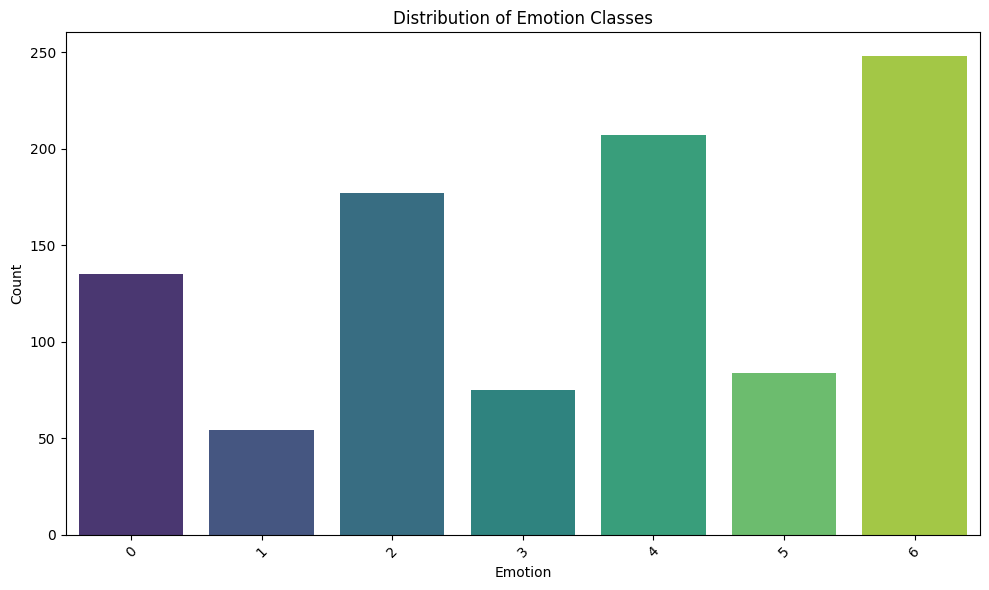

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your encoded CSV file
csv_path = 'processed_faces_newFinal/encoded_landmarks.csv'
df = pd.read_csv(csv_path)

# # Show basic info and a preview
# print(df.info())
# print(df.head())

# Count plot of emotion classes
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='emotion', palette='viridis')
plt.title('Distribution of Emotion Classes')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # Define the path to your encoded CSV file
# # This path assumes 'encoded_landmarks.csv' is inside 'processed_faces_newFinal'
# # which is itself inside your main project folder.
# encoded_csv_path = 'processed_faces_newFinal/encoded_landmarks.csv'

# try:
#     # Load the encoded data
#     df_encoded = pd.read_csv(encoded_csv_path)
#     print(f"Successfully loaded data from: {encoded_csv_path}")
#     print("DataFrame head (first 5 rows):")
#     print(df_encoded.head())

#     # Separate features (X) and target (y)
#     # X will contain all landmark coordinates (columns starting with 'landmark_')
#     # y will contain the encoded 'emotion' label
#     X = df_encoded.drop('emotion', axis=1) # Drop the 'emotion' column to get features
#     y = df_encoded['emotion']              # Select only the 'emotion' column as the target

#     print(f"\nFeatures (X) shape: {X.shape}")
#     print(f"Target (y) shape: {y.shape}")

#     # Perform the train-test split
#     # test_size=0.20 means 20% of the data will be used for testing, 80% for training
#     # random_state ensures reproducibility of the split (you'll get the same split every time)
#     # stratify=y ensures that the proportion of each emotion class is the same in both
#     # training and testing sets, which is crucial for imbalanced datasets.
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

#     print("\nData split successfully!")
#     print(f"X_train shape (training features): {X_train.shape}")
#     print(f"X_test shape (testing features): {X_test.shape}")
#     print(f"y_train shape (training labels): {y_train.shape}")
#     print(f"y_test shape (testing labels): {y_test.shape}")

#     # You can optionally save these split datasets if needed for later use
#     X_train.to_csv('processed_faces_newFinal/train_and_test/train/X_train.csv', index=False)
#     X_test.to_csv('processed_faces_newFinal/train_and_test/test/X_test.csv', index=False)
#     y_train.to_csv('processed_faces_newFinal/train_and_test/train/y_train.csv', index=False)
#     y_test.to_csv('processed_faces_newFinal/train_and_test/test/y_test.csv', index=False)
#     print("\nSplit datasets optionally saved to processed_faces_newFinal/ as X_train.csv, X_test.csv, y_train.csv, y_test.csv")

# except FileNotFoundError:
#     print(f"Error: The file '{encoded_csv_path}' was not found.")
#     print("Please ensure the previous steps completed successfully and the CSV file exists at the specified path.")
# except Exception as e:
#     print(f"An error occurred: {e}")




import pandas as pd
import os
from sklearn.model_selection import train_test_split
import joblib # Import joblib for efficient saving/loading of numpy arrays/dataframes

# Define the path to your encoded CSV file
encoded_csv_path = 'processed_faces_newFinal/encoded_landmarks.csv'
output_dir = 'processed_faces_newFinal/train_test_split' # Define output directory for split data

try:
    # Load the encoded data
    df_encoded = pd.read_csv(encoded_csv_path)
    print(f"Successfully loaded data from: {encoded_csv_path}")
    print("DataFrame head (first 5 rows):")
    print(df_encoded.head())

    # Separate features (X) and target (y)
    X = df_encoded.drop('emotion', axis=1)
    y = df_encoded['emotion']

    print(f"\nFeatures (X) shape: {X.shape}")
    print(f"Target (y) shape: {y.shape}")

    # Perform the train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

    print("\nData split successfully!")
    print(f"X_train shape (training features): {X_train.shape}")
    print(f"X_test shape (testing features): {X_test.shape}")
    print(f"y_train shape (training labels): {y_train.shape}")
    print(f"y_test shape (testing labels): {y_test.shape}")

    # --- Save the split datasets ---
    # Using joblib.dump is efficient for saving large arrays/DataFrames
    joblib.dump(X_train, os.path.join(output_dir, 'X_train.joblib'))
    joblib.dump(X_test, os.path.join(output_dir, 'X_test.joblib'))
    joblib.dump(y_train, os.path.join(output_dir, 'y_train.joblib'))
    joblib.dump(y_test, os.path.join(output_dir, 'y_test.joblib'))
    
    print(f"\n✅ Split datasets saved to {output_dir}/ as X_train.joblib, X_test.joblib, y_train.joblib, y_test.joblib")

except FileNotFoundError:
    print(f"Error: The file '{encoded_csv_path}' was not found.")
    print("Please ensure the previous steps completed successfully and the CSV file exists at the specified path.")
except Exception as e:
    print(f"An error occurred: {e}")



Successfully loaded data from: processed_faces_newFinal/encoded_landmarks.csv
DataFrame head (first 5 rows):
   emotion  landmark_0_x  landmark_0_y  landmark_1_x  landmark_1_y  \
0        0            61           258            64           319   
1        0            56           264            60           325   
2        0            67           258            69           318   
3        0             3           227            11           295   
4        0             7           227            16           293   

   landmark_2_x  landmark_2_y  landmark_3_x  landmark_3_y  landmark_4_x  ...  \
0            70           375            83           428           104  ...   
1            66           382            80           436           103  ...   
2            75           374            87           428           108  ...   
3            25           359            42           421            67  ...   
4            29           356            46           418            6

In [1]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib 
import json 

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define the root directories for input and output
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal"

# Define the scaling factor for upscaling images
scale_factor = 12

# Create the root output directory if it doesn't exist
os.makedirs(root_output_dir, exist_ok=True)

# List of emotion folders
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

# Define Valence and Arousal values for each emotion (based on common psychological models)
# These are approximate values. Range is typically -1 to +1 for both.
emotion_va_mapping = {
    "anger":     {"valence": -0.5, "arousal": 0.8},  # Negative, High Arousal
    "contempt":  {"valence": -0.6, "arousal": 0.3},  # Negative, Moderate Arousal
    "disgust":   {"valence": -0.6, "arousal": 0.6},  # Negative, High Arousal
    "happy":     {"valence": 0.8,  "arousal": 0.7},  # Positive, High Arousal
    "sadness":   {"valence": -0.7, "arousal": 0.2},  # Negative, Low Arousal
    "fear":      {"valence": -0.8, "arousal": 0.9},  # Very Negative, Very High Arousal
    "surprise":  {"valence": 0.3,  "arousal": 0.7}   # Slightly Positive, High Arousal (can be neutral valence too)
}


# List to store all landmark data for CSV export
all_landmarks_data = []

print("Starting facial landmark detection and processing for ALL photos...")
print("Output images will be split into '_with_photo' and '_without_photo' folders.")
print("A comprehensive CSV file with landmark coordinates will also be generated.")
print("Emotion label mapping AND Valence/Arousal values will be saved.")


for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)
    
    output_with_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_with_photo")
    output_without_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_without_photo")

    os.makedirs(output_with_photo_path, exist_ok=True)
    os.makedirs(output_without_photo_path, exist_ok=True)
    
    print(f"\nProcessing emotion: {emotion}...")

    for filename in os.listdir(input_emotion_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue
                
            print(f"  Processing file: {filename}")

            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)

            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)

                landmark_row = {'emotion': emotion, 'filename': filename}
                for n in range(68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    landmark_row[f'landmark_{n}_x'] = x
                    landmark_row[f'landmark_{n}_y'] = y
                all_landmarks_data.append(landmark_row)

                drawn_image_with_photo = upscaled_image.copy() 
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8) 

                nose_x = landmarks.part(30).x
                nose_y = landmarks.part(30).y

                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1)
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1)

                drawn_index = 1
                seen = set()

                for n in range(68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y

                    if (x, y) in seen:
                        continue
                    seen.add((x, y))

                    circle_color = (0, 0, 255) 
                    circle_radius = 2 
                    if n == 30: 
                        circle_radius = 5
                    fill_type = -1 

                    text_font = cv2.FONT_HERSHEY_SIMPLEX
                    text_scale = 0.35
                    if n == 30: 
                        text_scale = 0.8
                    
                    offset_x, offset_y = -6, 10
                    if n in [37, 38, 39, 43, 44, 45]:
                        offset_y = -10
                    elif n == 49:
                        offset_x = -20
                        offset_y = 6
                    elif n == 50:
                        offset_x = 0
                        offset_y = -8
                    elif n == 65:
                        offset_x = -14
                        offset_y = 10
                    elif 48 <= n <= 54:
                        offset_y = -8
                    elif 55 <= n <= 59:
                        offset_y = 10
                    elif 60 <= n <= 64:
                        offset_y = -8
                    elif 65 <= n <= 67:
                        offset_y = 10
                    
                    text_color_with_photo = (0, 0, 0)
                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, circle_color, fill_type)
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, text_color_with_photo, 1, cv2.LINE_AA)

                    text_color_without_photo = (255, 255, 255)
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, text_color_without_photo, fill_type) 
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, text_color_without_photo, 1, cv2.LINE_AA)

                    drawn_index += 1

                output_image_path_with_photo = os.path.join(output_with_photo_path, filename)
                cv2.imwrite(output_image_path_with_photo, drawn_image_with_photo)
                
                output_image_path_without_photo = os.path.join(output_without_photo_path, filename)
                cv2.imwrite(output_image_path_without_photo, drawn_image_without_photo)
                
            else:
                print(f"  No face detected in {filename} from {emotion} folder.")
            
print("\nAll emotion folders and photos processed successfully!")

# --- Save all collected landmark data to a single CSV file ---
if all_landmarks_data:
    df = pd.DataFrame(all_landmarks_data)
    csv_output_path = os.path.join(root_output_dir, "facial_landmarks_data.csv")
    df.to_csv(csv_output_path, index=False)
    print(f"All facial landmark coordinates saved to: {csv_output_path}")
else:
    print("No facial landmark data was collected (no faces detected or no images processed).")


# --- Data Cleaning, Label Encoding, and Mapping Saving (Modified for V-A) ---

# Load the CSV file generated from landmark extraction
csv_path = os.path.join(root_output_dir, "facial_landmarks_data.csv")
df = pd.read_csv(csv_path)

# Drop the filename column (not required for training)
if 'filename' in df.columns:
    df.drop('filename', axis=1, inplace=True)

# Path for cleaned version
cleaned_csv_path = os.path.join(root_output_dir, 'cleaned_facial_landmarks_data.csv') 

# Drop rows with any missing values
df.dropna(inplace=True)

# Ensure all coordinate columns are numeric (except emotion)
columns_to_check = df.columns.difference(['emotion'])
df[columns_to_check] = df[columns_to_check].apply(pd.to_numeric, errors='coerce')

# Drop any rows that still contain NaNs after conversion
df.dropna(inplace=True)

# Drop duplicate rows
df.drop_duplicates(inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

# --- Add Valence and Arousal columns BEFORE label encoding ---
# Use the defined emotion_va_mapping to add V and A columns
df['valence'] = df['emotion'].map(lambda x: emotion_va_mapping[x]['valence'])
df['arousal'] = df['emotion'].map(lambda x: emotion_va_mapping[x]['arousal'])

# Save cleaned data (now including Valence and Arousal)
df.to_csv(cleaned_csv_path, index=False)
print(f"\n✅ Cleaned data (with Valence and Arousal) saved to: {cleaned_csv_path}")

# --- Proceed with Label Encoding for the original 'emotion' if still needed ---
# Note: For V-A prediction, you would train a regression model directly on 'valence'/'arousal'.
# For categorical emotion classification, you still need 'emotion' column encoded.
le = LabelEncoder()
df['emotion_encoded'] = le.fit_transform(df['emotion']) # Renamed column to emotion_encoded for clarity

# Save the DataFrame with encoded emotion labels AND V-A values
encoded_csv_path = os.path.join(root_output_dir, 'encoded_landmarks_with_va.csv') # New filename
df.to_csv(encoded_csv_path, index=False)
print(f"Encoded data (with V-A) saved to {encoded_csv_path}")

# Get and save the label mapping for categorical emotions
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
label_mapping_path = os.path.join(root_output_dir, 'emotion_label_mapping.json')
with open(label_mapping_path, 'w') as f:
    json.dump(label_mapping, f, indent=4)
print(f"✅ Emotion label mapping saved to: {label_mapping_path}")

print("\nAll data processing, encoding, and V-A integration steps complete. Ready for next step.")



Starting facial landmark detection and processing for ALL photos...
Output images will be split into '_with_photo' and '_without_photo' folders.
A comprehensive CSV file with landmark coordinates will also be generated.
Emotion label mapping AND Valence/Arousal values will be saved.

Processing emotion: anger...
  Processing file: S010_004_00000017.png
  Processing file: S010_004_00000018.png
  Processing file: S010_004_00000019.png
  Processing file: S011_004_00000019.png
  Processing file: S011_004_00000020.png
  Processing file: S011_004_00000021.png
  Processing file: S014_003_00000028.png
  Processing file: S014_003_00000029.png
  Processing file: S014_003_00000030.png
  Processing file: S022_005_00000030.png
  Processing file: S022_005_00000031.png
  Processing file: S022_005_00000032.png
  Processing file: S026_003_00000013.png
  Processing file: S026_003_00000014.png
  Processing file: S026_003_00000015.png
  Processing file: S028_001_00000022.png
  Processing file: S028_001_00

TypeError: Object of type int32 is not JSON serializable

In [1]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib 
import json 
from scipy.spatial import distance as dist # For calculating Euclidean distances

# --- Helper function to convert dlib landmarks object to a NumPy array ---
def shape_to_np(shape, dtype="int"):
    # Initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
    # Loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    # Return the list of (x, y)-coordinates
    return coords

# --- Helper functions for geometric features ---
def eye_aspect_ratio(eye):
    # compute the Euclidean distances between the two sets of
    # vertical eye landmarks (x, y)-coordinates
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    # compute the Euclidean distance between the horizontal
    # eye landmark (x, y)-coordinates
    C = dist.euclidean(eye[0], eye[3])
    # compute the eye aspect ratio
    ear = (A + B) / (2.0 * C)
    # return the eye aspect ratio
    return ear

def mouth_aspect_ratio(mouth):
    # compute the Euclidean distances between the two sets of
    # vertical mouth landmarks (x, y)-coordinates
    A = dist.euclidean(mouth[1], mouth[7])
    B = dist.euclidean(mouth[2], mouth[6])
    C = dist.euclidean(mouth[3], mouth[5])
    # compute the Euclidean distance between the horizontal
    # mouth landmark (x, y)-coordinates
    D = dist.euclidean(mouth[0], mouth[4])
    # compute the mouth aspect ratio
    mar = (A + B + C) / (3.0 * D)
    # return the mouth aspect ratio
    return mar

# --- Function to calculate all geometric features ---
def calculate_geometric_features(landmarks_np):
    features = {}

    # Eye Aspect Ratios (EAR)
    # Left eye: 42-47
    left_eye_points = landmarks_np[42:48]
    features['left_ear'] = eye_aspect_ratio(left_eye_points)
    # Right eye: 36-41
    right_eye_points = landmarks_np[36:42]
    features['right_ear'] = eye_aspect_ratio(right_eye_points)
    features['avg_ear'] = (features['left_ear'] + features['right_ear']) / 2.0

    # Mouth Aspect Ratio (MAR)
    # Mouth: 60-67 (inner mouth)
    mouth_points = landmarks_np[60:68]
    features['mar'] = mouth_aspect_ratio(mouth_points)

    # Distances between key points
    # Eyebrow vertical distance (e.g., between inner eyebrow points and eye points)
    # Left eyebrow (21) to left eye (40)
    features['left_eyebrow_eye_dist'] = dist.euclidean(landmarks_np[21], landmarks_np[40])
    # Right eyebrow (22) to right eye (43)
    features['right_eyebrow_eye_dist'] = dist.euclidean(landmarks_np[22], landmarks_np[43])
    
    # Distance between nose tip (30) and chin (8)
    features['nose_chin_vertical_dist'] = dist.euclidean(landmarks_np[30], landmarks_np[8])

    # Distance between left (48) and right (54) mouth corners
    features['mouth_width'] = dist.euclidean(landmarks_np[48], landmarks_np[54])
    
    # Example: Nose width (distance between points 31 and 35)
    features['nose_width'] = dist.euclidean(landmarks_np[31], landmarks_np[35])


    # Add more features as needed for "mid-level" (e.g., average curvature of eyebrow points)
    # or "high-level" features (e.g., dynamic changes over time, which requires video input)
    # For now, these are considered "low-level" geometric features.

    return features

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define the root directories for input and output
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal"

# Define the scaling factor for upscaling images
scale_factor = 12

# Create the root output directory if it doesn't exist
os.makedirs(root_output_dir, exist_ok=True)

# List of emotion folders
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

# Define Valence and Arousal values for each emotion (based on common psychological models)
emotion_va_mapping = {
    "anger":     {"valence": -0.5, "arousal": 0.8},
    "contempt":  {"valence": -0.6, "arousal": 0.3},
    "disgust":   {"valence": -0.6, "arousal": 0.6},
    "happy":     {"valence": 0.8,  "arousal": 0.7},
    "sadness":   {"valence": -0.7, "arousal": 0.2},
    "fear":      {"valence": -0.8, "arousal": 0.9},
    "surprise":  {"valence": 0.3,  "arousal": 0.7}
}

# List to store all landmark data for CSV export
all_landmarks_data = []

print("Starting facial landmark detection and processing for ALL photos...")
print("Output images will be split into '_with_photo' and '_without_photo' folders.")
print("A comprehensive CSV file with landmark coordinates AND geometric features will be generated.")
print("Emotion label mapping AND Valence/Arousal values will be saved.")


for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)
    
    output_with_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_with_photo")
    output_without_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_without_photo")

    os.makedirs(output_with_photo_path, exist_ok=True)
    os.makedirs(output_without_photo_path, exist_ok=True)
    
    print(f"\nProcessing emotion: {emotion}...")

    for filename in os.listdir(input_emotion_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue
                
            # print(f"  Processing file: {filename}") # Uncomment for very verbose output

            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)

            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)
                landmarks_np = shape_to_np(landmarks) # Convert to NumPy array once

                landmark_row = {'emotion': emotion, 'filename': filename}
                
                # Add raw landmark coordinates
                for n in range(68):
                    x = landmarks_np[n, 0] # Use numpy array indexing
                    y = landmarks_np[n, 1] # Use numpy array indexing
                    landmark_row[f'landmark_{n}_x'] = x
                    landmark_row[f'landmark_{n}_y'] = y
                
                # --- Calculate and add geometric features ---
                geometric_features = calculate_geometric_features(landmarks_np)
                landmark_row.update(geometric_features) # Add these new features to the row

                all_landmarks_data.append(landmark_row)

                # --- Quadrant-based V-A and Landmark Verification (Needs formulas/criteria) ---
                # NOTE TO USER: If you have specific formulas for calculating Valence and Arousal
                # per quadrant based on landmarks, and criteria for verifying landmark correctness
                # using these V-A values, please provide them. We can integrate them here.
                # For now, we proceed with drawing the image.
                # Example placeholder if you provided logic:
                # quadrant1_valence = calculate_valence_quadrant1(landmarks_np)
                # if quadrant1_valence > threshold:
                #    print("Landmarks in Q1 might be off!")


                drawn_image_with_photo = upscaled_image.copy() 
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8) 

                nose_x = landmarks_np[30, 0]
                nose_y = landmarks_np[30, 1]

                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1)
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1)

                drawn_index = 1
                seen = set()

                for n in range(68):
                    x = landmarks_np[n, 0]
                    y = landmarks_np[n, 1]

                    if (x, y) in seen:
                        continue
                    seen.add((x, y))

                    circle_color = (0, 0, 255) 
                    circle_radius = 2 
                    if n == 30: 
                        circle_radius = 5
                    fill_type = -1 

                    text_font = cv2.FONT_HERSHEY_SIMPLEX
                    text_scale = 0.35
                    if n == 30: 
                        text_scale = 0.8
                    
                    offset_x, offset_y = -6, 10
                    if n in [37, 38, 39, 43, 44, 45]:
                        offset_y = -10
                    elif n == 49:
                        offset_x = -20
                        offset_y = 6
                    elif n == 50:
                        offset_x = 0
                        offset_y = -8
                    elif n == 65:
                        offset_x = -14
                        offset_y = 10
                    elif 48 <= n <= 54:
                        offset_y = -8
                    elif 55 <= n <= 59:
                        offset_y = 10
                    elif 60 <= n <= 64:
                        offset_y = -8
                    elif 65 <= n <= 67:
                        offset_y = 10
                    
                    text_color_with_photo = (0, 0, 0)
                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, circle_color, fill_type)
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, text_color_with_photo, 1, cv2.LINE_AA)

                    text_color_without_photo = (255, 255, 255)
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, text_color_without_photo, fill_type) 
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, text_color_without_photo, 1, cv2.LINE_AA)

                    drawn_index += 1

                output_image_path_with_photo = os.path.join(output_with_photo_path, filename)
                cv2.imwrite(output_image_path_with_photo, drawn_image_with_photo)
                
                output_image_path_without_photo = os.path.join(output_without_photo_path, filename)
                cv2.imwrite(output_image_path_without_photo, drawn_image_without_photo)
                
            else:
                print(f"  No face detected in {filename} from {emotion} folder.")
            
print("\nAll emotion folders and photos processed successfully!")

# --- Save all collected landmark data to a single CSV file ---
if all_landmarks_data:
    df = pd.DataFrame(all_landmarks_data)
    csv_output_path = os.path.join(root_output_dir, "facial_landmarks_data.csv")
    df.to_csv(csv_output_path, index=False)
    print(f"All facial landmark coordinates saved to: {csv_output_path}")
else:
    print("No facial landmark data was collected (no faces detected or no images processed).")


# --- Data Cleaning, Label Encoding, and Mapping Saving (Modified for V-A and Geometric Features) ---

csv_path = os.path.join(root_output_dir, "facial_landmarks_data.csv")
df = pd.read_csv(csv_path)

if 'filename' in df.columns:
    df.drop('filename', axis=1, inplace=True)

cleaned_csv_path = os.path.join(root_output_dir, 'cleaned_facial_landmarks_data.csv') 

df.dropna(inplace=True)

# Ensure all columns are numeric except 'emotion' (and 'valence', 'arousal' which will be added)
# Temporarily exclude 'emotion' before mapping
cols_to_convert = df.columns.difference(['emotion'])
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# Add Valence and Arousal columns
df['valence'] = df['emotion'].map(lambda x: emotion_va_mapping[x]['valence'])
df['arousal'] = df['emotion'].map(lambda x: emotion_va_mapping[x]['arousal'])

df.to_csv(cleaned_csv_path, index=False)
print(f"\n✅ Cleaned data (with Valence, Arousal, and Geometric Features) saved to: {cleaned_csv_path}")

le = LabelEncoder()
df['emotion_encoded'] = le.fit_transform(df['emotion']) 

encoded_csv_path = os.path.join(root_output_dir, 'encoded_landmarks_with_va_geometric.csv') # NEW filename
df.to_csv(encoded_csv_path, index=False)
print(f"Encoded data (with V-A and Geometric Features) saved to {encoded_csv_path}")

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
serializable_label_mapping = {k: int(v) for k, v in label_mapping.items()}

label_mapping_path = os.path.join(root_output_dir, 'emotion_label_mapping.json')
with open(label_mapping_path, 'w') as f:
    json.dump(serializable_label_mapping, f, indent=4)
print(f"✅ Emotion label mapping saved to: {label_mapping_path}")

print("\nAll data processing, encoding, V-A integration, and geometric feature extraction complete. Ready for next step.")



Starting facial landmark detection and processing for ALL photos...
Output images will be split into '_with_photo' and '_without_photo' folders.
A comprehensive CSV file with landmark coordinates AND geometric features will be generated.
Emotion label mapping AND Valence/Arousal values will be saved.

Processing emotion: anger...

Processing emotion: contempt...

Processing emotion: disgust...

Processing emotion: happy...

Processing emotion: sadness...

Processing emotion: fear...

Processing emotion: surprise...
  No face detected in S051_002_00000017.png from surprise folder.

All emotion folders and photos processed successfully!
All facial landmark coordinates saved to: processed_faces_newFinal\facial_landmarks_data.csv

✅ Cleaned data (with Valence, Arousal, and Geometric Features) saved to: processed_faces_newFinal\cleaned_facial_landmarks_data.csv
Encoded data (with V-A and Geometric Features) saved to processed_faces_newFinal\encoded_landmarks_with_va_geometric.csv
✅ Emotion 

In [2]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib 
import json 
from scipy.spatial import distance as dist # For calculating Euclidean distances

# --- Helper function to convert dlib landmarks object to a NumPy array ---
def shape_to_np(shape, dtype="int"):
    # Initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
    # Loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    # Return the list of (x, y)-coordinates
    return coords

# --- Helper functions for geometric features ---
def eye_aspect_ratio(eye):
    # compute the Euclidean distances between the two sets of
    # vertical eye landmarks (x, y)-coordinates
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    # compute the Euclidean distance between the horizontal
    # eye landmark (x, y)-coordinates
    C = dist.euclidean(eye[0], eye[3])
    # compute the eye aspect ratio
    ear = (A + B) / (2.0 * C)
    # return the eye aspect ratio
    return ear

def mouth_aspect_ratio(mouth):
    # compute the Euclidean distances between the two sets of
    # vertical mouth landmarks (x, y)-coordinates
    A = dist.euclidean(mouth[1], mouth[7])
    B = dist.euclidean(mouth[2], mouth[6])
    C = dist.euclidean(mouth[3], mouth[5])
    # compute the Euclidean distance between the horizontal
    # mouth landmark (x, y)-coordinates
    D = dist.euclidean(mouth[0], mouth[4])
    # compute the mouth aspect ratio
    mar = (A + B + C) / (3.0 * D)
    # return the mouth aspect ratio
    return mar

# --- Function to calculate all geometric features ---
def calculate_geometric_features(landmarks_np):
    features = {}

    # --- Low-Level Features (Direct Distances/Ratios) ---

    # Eye Aspect Ratios (EAR)
    left_eye_points = landmarks_np[42:48]
    features['left_ear'] = eye_aspect_ratio(left_eye_points)
    right_eye_points = landmarks_np[36:42]
    features['right_ear'] = eye_aspect_ratio(right_eye_points)
    features['avg_ear'] = (features['left_ear'] + features['right_ear']) / 2.0

    # Mouth Aspect Ratio (MAR)
    mouth_points = landmarks_np[60:68] # Inner mouth points
    features['mar'] = mouth_aspect_ratio(mouth_points)

    # Basic Distances between key points
    features['left_eyebrow_eye_dist'] = dist.euclidean(landmarks_np[21], landmarks_np[40]) # Left inner eyebrow to lower eye
    features['right_eyebrow_eye_dist'] = dist.euclidean(landmarks_np[22], landmarks_np[43]) # Right inner eyebrow to lower eye
    features['nose_chin_vertical_dist'] = dist.euclidean(landmarks_np[30], landmarks_np[8]) # Nose tip to chin bottom
    features['mouth_width'] = dist.euclidean(landmarks_np[48], landmarks_np[54]) # Left mouth corner to right mouth corner
    features['nose_width'] = dist.euclidean(landmarks_np[31], landmarks_np[35]) # Nose left to nose right

    # --- Mid-Level Features (More complex ratios, proportions, areas) ---

    # Inter-ocular distance (reference for normalization)
    # Distance between the centers of the eyes (using points 39 and 42 for inner eye corners)
    left_eye_center = np.mean([landmarks_np[36], landmarks_np[37], landmarks_np[38], landmarks_np[39], landmarks_np[40], landmarks_np[41]], axis=0)
    right_eye_center = np.mean([landmarks_np[42], landmarks_np[43], landmarks_np[44], landmarks_np[45], landmarks_np[46], landmarks_np[47]], axis=0)
    features['inter_ocular_dist'] = dist.euclidean(left_eye_center, right_eye_center)

    # Normalized distances (divide by inter_ocular_dist to make them scale-invariant)
    if features['inter_ocular_dist'] > 0: # Avoid division by zero
        features['norm_nose_chin_vertical_dist'] = features['nose_chin_vertical_dist'] / features['inter_ocular_dist']
        features['norm_mouth_width'] = features['mouth_width'] / features['inter_ocular_dist']
        features['norm_nose_width'] = features['nose_width'] / features['inter_ocular_dist']
        features['norm_left_eyebrow_eye_dist'] = features['left_eyebrow_eye_dist'] / features['inter_ocular_dist']
        features['norm_right_eyebrow_eye_dist'] = features['right_eyebrow_eye_dist'] / features['inter_ocular_dist']
    else: # Handle cases where inter_ocular_dist might be zero (e.g., no eyes detected properly)
        features['norm_nose_chin_vertical_dist'] = 0.0
        features['norm_mouth_width'] = 0.0
        features['norm_nose_width'] = 0.0
        features['norm_left_eyebrow_eye_dist'] = 0.0
        features['norm_right_eyebrow_eye_dist'] = 0.0

    # Eye Area (approximate using convex hull/polygon area)
    # Using shoelace formula for polygon area (approximate for eye shape)
    def polygon_area(points):
        x = points[:, 0]
        y = points[:, 1]
        return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

    features['left_eye_area'] = polygon_area(left_eye_points)
    features['right_eye_area'] = polygon_area(right_eye_points)
    
    # Mouth Area (approximate using inner mouth landmarks 60-67)
    features['mouth_area'] = polygon_area(mouth_points)


    # Eyebrow shape (e.g., distance from top of eyebrow to line connecting ends)
    # Left eyebrow: points 17-21
    # Right eyebrow: points 22-26
    features['left_eyebrow_raise'] = dist.euclidean(landmarks_np[19], (landmarks_np[17] + landmarks_np[21]) / 2) # Midpoint to line
    features['right_eyebrow_raise'] = dist.euclidean(landmarks_np[24], (landmarks_np[22] + landmarks_np[26]) / 2)

    # Ratio of mouth height to mouth width (a more nuanced MAR)
    if features['mouth_width'] > 0:
        features['mouth_height_width_ratio'] = dist.euclidean(landmarks_np[62], landmarks_np[66]) / features['mouth_width'] # Upper inner lip to lower inner lip
    else:
        features['mouth_height_width_ratio'] = 0.0

    return features

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define the root directories for input and output
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal"

# Define the scaling factor for upscaling images
scale_factor = 12

# Create the root output directory if it doesn't exist
os.makedirs(root_output_dir, exist_ok=True)

# List of emotion folders
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

# Define Valence and Arousal values for each emotion (based on common psychological models)
emotion_va_mapping = {
    "anger":     {"valence": -0.5, "arousal": 0.8},
    "contempt":  {"valence": -0.6, "arousal": 0.3},
    "disgust":   {"valence": -0.6, "arousal": 0.6},
    "happy":     {"valence": 0.8,  "arousal": 0.7},
    "sadness":   {"valence": -0.7, "arousal": 0.2},
    "fear":      {"valence": -0.8, "arousal": 0.9},
    "surprise":  {"valence": 0.3,  "arousal": 0.7}
}

# List to store all landmark data for CSV export
all_landmarks_data = []

print("Starting facial landmark detection and processing for ALL photos...")
print("Output images will be split into '_with_photo' and '_without_photo' folders.")
print("A comprehensive CSV file with landmark coordinates AND geometric features will be generated.")
print("Emotion label mapping AND Valence/Arousal values will be saved.")


for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)
    
    output_with_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_with_photo")
    output_without_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_without_photo")

    os.makedirs(output_with_photo_path, exist_ok=True)
    os.makedirs(output_without_photo_path, exist_ok=True)
    
    print(f"\nProcessing emotion: {emotion}...")

    for filename in os.listdir(input_emotion_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue
                
            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)

            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)
                landmarks_np = shape_to_np(landmarks) # Convert to NumPy array once

                landmark_row = {'emotion': emotion, 'filename': filename}
                
                # Add raw landmark coordinates (low-level)
                for n in range(68):
                    x = landmarks_np[n, 0] 
                    y = landmarks_np[n, 1] 
                    landmark_row[f'landmark_{n}_x'] = x
                    landmark_row[f'landmark_{n}_y'] = y
                
                # --- Calculate and add geometric features (mid-level) ---
                geometric_features = calculate_geometric_features(landmarks_np)
                landmark_row.update(geometric_features) 

                all_landmarks_data.append(landmark_row)

                # --- Quadrant-based V-A and Landmark Verification (Needs formulas/criteria) ---
                # This section is a placeholder. If you provide the specific formulas for
                # calculating Valence and Arousal per quadrant from landmarks, and
                # how to use those for verification, we can add that logic here.
                # For example:
                # Q1 (Top-Right): landmarks 17-21 (left eyebrow), 36-39 (left eye outer) etc.
                # Q2 (Top-Left): landmarks 22-26 (right eyebrow), 42-45 (right eye outer) etc.
                # Q3 (Bottom-Left): landmarks 48-51 (left mouth), 8 (chin) etc.
                # Q4 (Bottom-Right): landmarks 52-54 (right mouth), 8 (chin) etc.
                #
                # Then, based on quadrant-specific V/A, you'd add verification logic:
                # e.g., if calculated_valence_Q1 > some_threshold and emotion_is_sadness:
                #    print("Warning: Potential landmark misdetection in Q1 for sadness!")


                drawn_image_with_photo = upscaled_image.copy() 
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8) 

                nose_x = landmarks_np[30, 0]
                nose_y = landmarks_np[30, 1]

                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1)
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1)

                drawn_index = 1
                seen = set()

                for n in range(68):
                    x = landmarks_np[n, 0]
                    y = landmarks_np[n, 1]

                    if (x, y) in seen:
                        continue
                    seen.add((x, y))

                    circle_color = (0, 0, 255) 
                    circle_radius = 2 
                    if n == 30: 
                        circle_radius = 5
                    fill_type = -1 

                    text_font = cv2.FONT_HERSHEY_SIMPLEX
                    text_scale = 0.35
                    if n == 30: 
                        text_scale = 0.8
                    
                    offset_x, offset_y = -6, 10
                    if n in [37, 38, 39, 43, 44, 45]:
                        offset_y = -10
                    elif n == 49:
                        offset_x = -20
                        offset_y = 6
                    elif n == 50:
                        offset_x = 0
                        offset_y = -8
                    elif n == 65:
                        offset_x = -14
                        offset_y = 10
                    elif 48 <= n <= 54:
                        offset_y = -8
                    elif 55 <= n <= 59:
                        offset_y = 10
                    elif 60 <= n <= 64:
                        offset_y = -8
                    elif 65 <= n <= 67:
                        offset_y = 10
                    
                    text_color_with_photo = (0, 0, 0)
                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, circle_color, fill_type)
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, text_color_with_photo, 1, cv2.LINE_AA)

                    text_color_without_photo = (255, 255, 255)
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, text_color_without_photo, fill_type) 
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, text_color_without_photo, 1, cv2.LINE_AA)

                    drawn_index += 1

                output_image_path_with_photo = os.path.join(output_with_photo_path, filename)
                cv2.imwrite(output_image_path_with_photo, drawn_image_with_photo)
                
                output_image_path_without_photo = os.path.join(output_without_photo_path, filename)
                cv2.imwrite(output_image_path_without_photo, drawn_image_without_photo)
                
            else:
                print(f"  No face detected in {filename} from {emotion} folder.")
            
print("\nAll emotion folders and photos processed successfully!")

# --- Save all collected landmark data to a single CSV file ---
if all_landmarks_data:
    df = pd.DataFrame(all_landmarks_data)
    csv_output_path = os.path.join(root_output_dir, "facial_landmarks_data.csv")
    df.to_csv(csv_output_path, index=False)
    print(f"All facial landmark coordinates saved to: {csv_output_path}")
else:
    print("No facial landmark data was collected (no faces detected or no images processed).")


# --- Data Cleaning, Label Encoding, and Mapping Saving (Modified for V-A and Geometric Features) ---

csv_path = os.path.join(root_output_dir, "facial_landmarks_data.csv")
df = pd.read_csv(csv_path)

if 'filename' in df.columns:
    df.drop('filename', axis=1, inplace=True)

cleaned_csv_path = os.path.join(root_output_dir, 'cleaned_facial_landmarks_data.csv') 

df.dropna(inplace=True)

# Ensure all columns are numeric except 'emotion' (and 'valence', 'arousal' which will be added)
# Temporarily exclude 'emotion' before mapping
cols_to_convert = df.columns.difference(['emotion'])
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# Add Valence and Arousal columns
df['valence'] = df['emotion'].map(lambda x: emotion_va_mapping[x]['valence'])
df['arousal'] = df['emotion'].map(lambda x: emotion_va_mapping[x]['arousal'])

df.to_csv(cleaned_csv_path, index=False)
print(f"\n✅ Cleaned data (with Valence, Arousal, and Geometric Features) saved to: {cleaned_csv_path}")

le = LabelEncoder()
df['emotion_encoded'] = le.fit_transform(df['emotion']) 

encoded_csv_path = os.path.join(root_output_dir, 'encoded_landmarks_with_va_geometric.csv') # NEW filename
df.to_csv(encoded_csv_path, index=False)
print(f"Encoded data (with V-A and Geometric Features) saved to {encoded_csv_path}")

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
serializable_label_mapping = {k: int(v) for k, v in label_mapping.items()}

label_mapping_path = os.path.join(root_output_dir, 'emotion_label_mapping.json')
with open(label_mapping_path, 'w') as f:
    json.dump(serializable_label_mapping, f, indent=4)
print(f"✅ Emotion label mapping saved to: {label_mapping_path}")

print("\nAll data processing, encoding, V-A integration, and geometric feature extraction complete. Ready for next step.")



Starting facial landmark detection and processing for ALL photos...
Output images will be split into '_with_photo' and '_without_photo' folders.
A comprehensive CSV file with landmark coordinates AND geometric features will be generated.
Emotion label mapping AND Valence/Arousal values will be saved.

Processing emotion: anger...

Processing emotion: contempt...

Processing emotion: disgust...

Processing emotion: happy...

Processing emotion: sadness...

Processing emotion: fear...

Processing emotion: surprise...
  No face detected in S051_002_00000017.png from surprise folder.

All emotion folders and photos processed successfully!
All facial landmark coordinates saved to: processed_faces_newFinal\facial_landmarks_data.csv

✅ Cleaned data (with Valence, Arousal, and Geometric Features) saved to: processed_faces_newFinal\cleaned_facial_landmarks_data.csv
Encoded data (with V-A and Geometric Features) saved to processed_faces_newFinal\encoded_landmarks_with_va_geometric.csv
✅ Emotion 